In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
from IPython.display import display
import io


In [73]:

def network_architecture( hidden_layers=10, units_per_hidden=50, output_layer=1):
    architecture = {
        
        'hidden_layers': hidden_layers, # # of hidden layers + 1 output layer
        'units_per_hidden': units_per_hidden,
        'output_layer': output_layer
    }

    return architecture



In [ ]:
def init_parameters(X):
    np.random.seed(42)
    parameters = {}
    architecture = network_architecture()
    hidden_layers, units_per_hidden = architecture['hidden_layers'], architecture['units_per_hidden']

    for i in range(1, hidden_layers + 1): 
        if i ==1: # Input layer
            parameters['W'+str(i)] = np.random.randn(units_per_hidden, X.shape[0]) * 0.01
        else:
            parameters['W'+str(i)] = np.random.randn(units_per_hidden, units_per_hidden) * 0.01 # Hidden layers
        parameters['b'+str(i)] = np.zeros((units_per_hidden,1))
    parameters['W'+str(hidden_layers + 1)] = np.random.randn(1, units_per_hidden) * 0.01 # Output layer
    parameters['b'+str(hidden_layers + 1)] = np.zeros((1,1))
    
    return parameters

In [53]:
def forward_propagation(X, parameters):
    cache = {}
    Z = {}
    A = X
    architecture = network_architecture()
    hidden_layers, units_per_hidden = architecture['hidden_layers'], architecture['units_per_hidden']

    for i in range(1, hidden_layers + 1):
        Z[i] = np.dot(parameters['W'+str(i)],A) + parameters['b'+str(i)]
        A = np.maximum(0,Z[i])  # ReLU activation
        cache['A'+str(i)] = A
        cache['Z'+str(i)] = Z[i]

    # Output layer
    Z[hidden_layers + 1] = np.dot(parameters['W'+str(hidden_layers + 1)], A) + parameters['b'+str(hidden_layers + 1)]
    Al = 1 / (1 + np.exp(-Z[hidden_layers + 1]))  # Sigmoid activation
    cache['AL'] = Al
    cache['ZL'] = Z[hidden_layers + 1]

    return Al , cache

In [ ]:
def cost_function(AL, Y):
    m = Y.shape[1]
    epsilon = 1e-15
    AL = np.clip(AL, epsilon, 1 - epsilon) # to avoid log(0)
    cost = - (1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost)
    return cost

In [7]:
def back_propagation(X, Y, cache, parameters):
    grads = {}
    m  = X.shape[1]
    architecture = network_architecture()
    hidden_layers, units_per_hidden = architecture['hidden_layers'], architecture['units_per_hidden']
    AL = cache['AL']
    epsilon = 1e-15
    AL = np.clip(AL, epsilon, 1 - epsilon)
    
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))# Derivative of cost w.r.t AL
    dZL = AL - Y
    dWL = np.dot(dZL, cache['A'+str(hidden_layers)].T) / m
    dbL = np.sum(dZL, axis=1, keepdims=True) / m
    grads['dW'+str(hidden_layers + 1)] = dWL 
    grads['db'+str(hidden_layers + 1)] = dbL
    
    dZ_next = dZL  

    for i in reversed(range(1, hidden_layers + 1)):

        dZ = dZ_next * (cache['Z'+str(i)] > 0)   
    
        A_prev = X if i == 1 else cache['A'+str(i-1)]
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
    
        grads['dW'+str(i)] = dW
        grads['db'+str(i)] = db
    
        dZ_next = np.dot(parameters['W'+str(i)].T, dZ)
    
    return grads



    

In [8]:
def update_parameters(parameters, grads, learning_rate):
    architecture = network_architecture()
    hidden_layers = architecture['hidden_layers']
    
    for i in range(1, hidden_layers + 2):
        parameters['W'+str(i)] -= learning_rate * grads['dW'+str(i)]
        parameters['b'+str(i)] -= learning_rate * grads['db'+str(i)]
        
    

    return parameters

In [56]:
def NN_model(X,Y, learning_rate = 0.01, num_iterations = 1000):
    parameters = init_parameters(X)
    costs = []
    

    for i in range(num_iterations):
        Al, cache = forward_propagation(X, parameters)
        cost = cost_function(Al, Y)
        costs.append(cost)
        grads = back_propagation(X, Y, cache, parameters)
        parameters_out = update_parameters(parameters, grads, learning_rate)

        
        if i % 1000 == 0:
            print(f"Cost after iteration {i}: {cost}")
    

    return parameters_out, costs

Testing the model

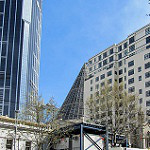

In [13]:
df = pd.read_parquet("0000.parquet") 
img_bytes = df.loc[12875, 'image']['bytes']
img = Image.open(io.BytesIO(img_bytes))
display(img)


In [10]:
target_size = (76, 76)  

def decode_image_rgb(byte_data):
    """Convert image bytes to flattened RGB array"""
    image = Image.open(io.BytesIO(byte_data))
    image = image.convert('RGB')               
    image = image.resize(target_size)          
    arr = np.array(image)                      
    return arr.flatten() 
X_list = [decode_image_rgb(img['bytes']) for img in df['image']]
X = np.array(X_list).T/255 

In [55]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X.T, df['label'], test_size=0.1, random_state=42)

X_dev_test, X_test, Y_dev_test, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_experiment, X_rest, Y_experiment, Y_rest = train_test_split(X_train, Y_train, test_size=0.9, random_state=42)

Y_train = np.array(Y_train).reshape(1, -1)
Y_dev_test = np.array(Y_dev_test).reshape(1, -1)
Y_test = np.array(Y_test).reshape(1, -1)

X_train = X_train.T
X_dev_test = X_dev_test.T
X_test = X_test.T

#print("Train set:", X_train.shape, Y_train.shape)
#print("Dev set:", X_dev_test.shape, Y_dev_test.shape)
#print("Test set:", X_test.shape, Y_test.shape)
print("Experiment set:", X_experiment.T.shape, Y_experiment.shape)

Experiment set: (17328, 1799) (1799,)


In [59]:
Y_experiment = np.array(Y_experiment).reshape(1, -1)
Y_experiment.shape

(1, 1799)

In [60]:
parameters, costs = NN_model(X_experiment.T, Y_experiment, learning_rate = 0.1, num_iterations = 1000)

Cost after iteration 0: 0.6931471805141128


In [61]:
def accuracy(Y_pred, Y_true):
    return np.mean(Y_pred == Y_true) * 100
def predict(X, parameters_out):
    AL, _ = forward_propagation(X, parameters_out)
    predictions = (AL > 0.5).astype(int)
    return predictions

In [62]:
Y_pred_exp = predict(X_experiment.T, parameters)
print("Train accuracy:", accuracy(Y_pred_exp, Y_experiment))

Train accuracy: 51.02834908282379


This example seems too complicated for a network withour proper regularization and parameters like He initialization. I tried several depths (hidden layers 5-50) and number of neurons in each layer (5-30) and neither helped. I believe that mini batches could help to run the algorithm faster, as the sample size is quite large as for a single MacBook. 

I will not try much easier example to check if my network can converge at all. 

In [63]:

np.random.seed(42)
num_ex = 200
# Cluster 1 (centered at [0,0])
cluster1 = np.random.randn(num_ex, 2) + np.array([0, 0])
labels1 = np.zeros((num_ex, 1))  # label 0

# Cluster 2 
cluster2 = np.random.randn(num_ex, 2) + np.array([5, 5])
labels2 = np.ones((num_ex, 1))   # label 1

# Combine data
X_cluster = np.vstack((cluster1, cluster2))    # shape (200, 2)
y_cluster = np.vstack((labels1, labels2))      # shape (200, 1)


In [64]:
X_cluster.T.shape, y_cluster.T.shape

((2, 400), (1, 400))

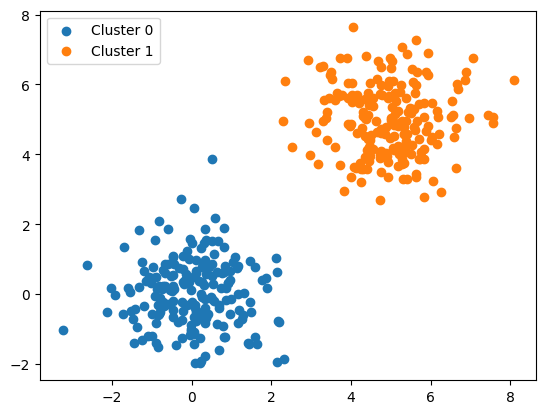

In [65]:


plt.scatter(X_cluster[y_cluster[:,0]==0, 0], X_cluster[y_cluster[:,0]==0, 1], label='Cluster 0')
plt.scatter(X_cluster[y_cluster[:,0]==1, 0], X_cluster[y_cluster[:,0]==1, 1], label='Cluster 1')
plt.legend()
plt.show()


In [66]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_cluster, y_cluster, test_size=0.3, random_state=42)

X_dev_test, X_test, Y_dev_test, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train = X_train.T
X_dev_test = X_dev_test.T
X_test = X_test.T   
Y_train = Y_train.T
Y_dev_test = Y_dev_test.T
Y_test = Y_test.T


print("Train set:", X_train.shape, Y_train.shape)
print("Dev set:", X_dev_test.shape, Y_dev_test.shape)
print("Test set:", X_test.shape, Y_test.shape)


Train set: (2, 280) (1, 280)
Dev set: (2, 60) (1, 60)
Test set: (2, 60) (1, 60)


In [68]:

parameters, costs = NN_model(X_train, Y_train, learning_rate=0.01, num_iterations=10000)

Y_pred_train = predict(X_train, parameters)
Y_pred_dev = predict(X_dev_test, parameters)
Y_pred_test = predict(X_test, parameters)


Cost after iteration 0: 0.693818514992339
Cost after iteration 1000: 0.12279951934516779
Cost after iteration 2000: 0.0636109229220452
Cost after iteration 3000: 0.042175073163336005
Cost after iteration 4000: 0.03135849572747834
Cost after iteration 5000: 0.02487237414327649
Cost after iteration 6000: 0.02057239168927968
Cost after iteration 7000: 0.017532158600846916
Cost after iteration 8000: 0.015268635239335028
Cost after iteration 9000: 0.013519594713624565


In [69]:
# achieved with hidden_layers=1, units_per_hidden=5, learning_rate=0.01, num_iterations=10000
print("Train accuracy:", accuracy(Y_pred_train, Y_train))
print("Dev accuracy:", accuracy(Y_pred_dev, Y_dev_test))
print("Test accuracy:", accuracy(Y_pred_test, Y_test))


Train accuracy: 100.0
Dev accuracy: 100.0
Test accuracy: 100.0


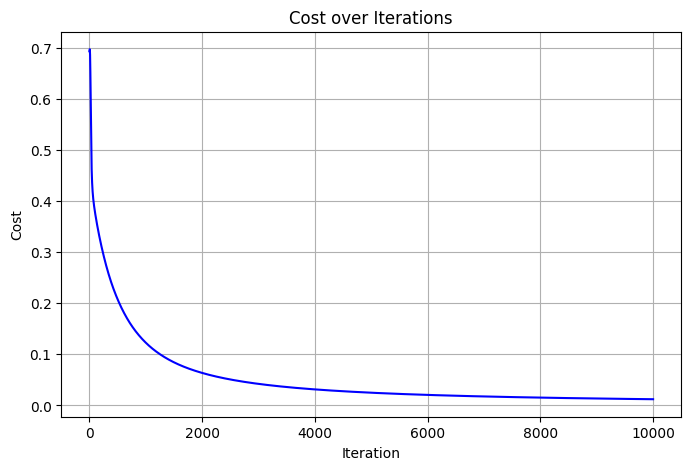

In [70]:

plt.figure(figsize=(8,5))
plt.plot(costs, color='blue')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost over Iterations")
plt.grid(True)
plt.show()

Cost after iteration 0: 0.693215748489298
Cost after iteration 1000: 0.12789875413238597
Cost after iteration 2000: 0.06624520153858227
Cost after iteration 3000: 0.04370740574640149
Cost after iteration 4000: 0.032423915865927216
Cost after iteration 5000: 0.02571213410938279
Cost after iteration 6000: 0.02127478139096642
Cost after iteration 7000: 0.018124310559558925
Cost after iteration 8000: 0.015780210490030692
Cost after iteration 9000: 0.013966273547563584
Train accuracy: 100.0
Dev accuracy: 100.0
Test accuracy: 100.0


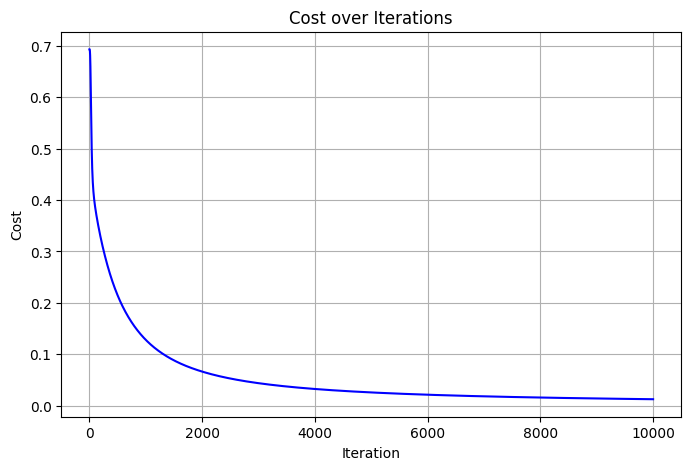

In [72]:
# achieved with hidden_layers=1, units_per_hidden=2, learning_rate=0.01, num_iterations=10000
parameters, costs = NN_model(X_train, Y_train, learning_rate=0.01, num_iterations=10000)

Y_pred_train = predict(X_train, parameters)
Y_pred_dev = predict(X_dev_test, parameters)
Y_pred_test = predict(X_test, parameters)

print("Train accuracy:", accuracy(Y_pred_train, Y_train))
print("Dev accuracy:", accuracy(Y_pred_dev, Y_dev_test))
print("Test accuracy:", accuracy(Y_pred_test, Y_test))

plt.figure(figsize=(8,5))
plt.plot(costs, color='blue')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost over Iterations")
plt.grid(True)
plt.show()

Cost after iteration 0: 0.6931471805599455
Cost after iteration 1000: 0.693045960461823
Cost after iteration 2000: 0.6930451424140623
Cost after iteration 3000: 0.6930451363178582
Cost after iteration 4000: 0.6930451362728922
Cost after iteration 5000: 0.6930451362725609
Cost after iteration 6000: 0.6930451362725585
Cost after iteration 7000: 0.6930451362725585
Cost after iteration 8000: 0.6930451362725583
Cost after iteration 9000: 0.6930451362725583
Train accuracy: 50.71428571428571
Dev accuracy: 51.66666666666667
Test accuracy: 45.0


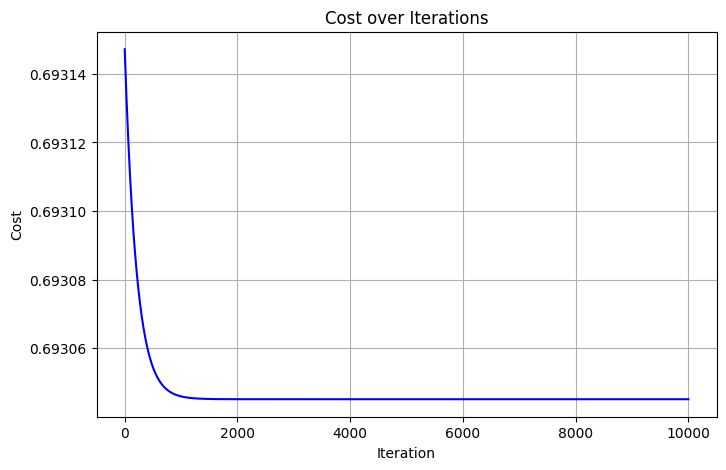

In [74]:
# achieved with hidden_layers=10, units_per_hidden=50, learning_rate=0.01, num_iterations=10000
parameters, costs = NN_model(X_train, Y_train, learning_rate=0.01, num_iterations=10000)

Y_pred_train = predict(X_train, parameters)
Y_pred_dev = predict(X_dev_test, parameters)
Y_pred_test = predict(X_test, parameters)

print("Train accuracy:", accuracy(Y_pred_train, Y_train))
print("Dev accuracy:", accuracy(Y_pred_dev, Y_dev_test))
print("Test accuracy:", accuracy(Y_pred_test, Y_test))

plt.figure(figsize=(8,5))
plt.plot(costs, color='blue')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost over Iterations")
plt.grid(True)
plt.show()

It seems that for this very simple example, the simplest network of 1 layer with 2 neurons is enough for this simple example. It is interesting how latger network (10 layers of 50 units each) produces random guess level of accuracy. It seems like without regularization there is too much noise.  

In the future, I intend to implement improvements like regulatization, He initialization, Adam optimizer and mini batches to the network and try it out on more challenging examples. And for the pictures I shall use CNN. 

So far, I'm glad my first (not so deep) Neural Network works!